In [1]:
import tensorflow as tf
import keras_tuner
import numpy as np


import pandas as pd
import openpyxl # Needed for reading excel
import pathlib

import decomposition
import models


In [4]:

cwd = pathlib.Path.cwd()

code_directory = cwd.parents[1]

bas_directory = code_directory / "notebooks" / "Bas"
gonem_directory = code_directory / "notebooks" / "Gonem"
# data_file = bas_directory / "cadeautjevoorGonemenLiza.xlsx"
data_file = gonem_directory / "MAIZE_FILTERED_2023-03-03_02-09-43.xlsx"
data_file


df = pd.read_excel(data_file, header=[0, 1], index_col=0)
df.head(5)

AVG_TAVG                                                  \
PARTNER_Labels      Brazil      France     Germany     Hungary     Ukraine   
TIME_PERIOD                                                                  
2005-01-01      269.701032   50.081198   28.651592   -1.306452    0.869290   
2005-02-01      266.743474   30.689158   -1.962406  -25.371429  -38.376438   
2005-03-01      266.528149   76.202630   45.730051   38.383871   -3.794989   
2005-04-01      253.719444  108.081105  101.859649  112.460000   90.622214   
2005-05-01      247.859946  147.068032  134.667233  162.993548  161.493475   

               Corn Price Futures MAX_TMAX                          \
PARTNER_Labels             Global   Brazil      France     Germany   
TIME_PERIOD                                                          
2005-01-01                 204.50   355.50  124.038462  129.842105   
2005-02-01                 222.75   342.50  119.983051  108.315789   
2005-03-01                 221.00   347.25  201.140625  180.894737   
2005-04-01                 213.50   338.50  254.950820  213.315789   
2005-05-01                 230.75   341.00  279.101695  314.684211   

                            ... renewable_energy_consumption_perc_of_total  \
PARTNER_Labels     Hungary  ...                                     Brazil   
TIME_PERIOD                 ...                                              
2005-01-01      137.000000  ...                                     46.130   
2005-02-01       57.666667  ...                                     46.175   
2005-03-01      209.000000  ...                                     46.220   
2005-04-01      218.000000  ...                                     46.265   
2005-05-01      321.000000  ...                                     46.310   

                                                   unemployment_total  \
PARTNER_Labels    France   Germany Hungary Ukraine             Brazil   
TIME_PERIOD                                                             
2005-01-01      8.660000  7.280000  7.2900    1.27          10.550000   
2005-02-01      8.648333  7.389167  7.3375    1.31          10.478333   
2005-03-01      8.636667  7.498333  7.3850    1.35          10.406667   
2005-04-01      8.625000  7.607500  7.4325    1.39          10.335000   
2005-05-01      8.613333  7.716667  7.4800    1.43          10.263333   

                                                       
PARTNER_Labels    France    Germany Hungary   Ukraine  
TIME_PERIOD                                            
2005-01-01      8.880000  11.170000   7.190  7.180000  
2005-02-01      8.875833  11.093333   7.215  7.149167  
2005-03-01      8.871667  11.016667   7.240  7.118333  
2005-04-01      8.867500  10.940000   7.265  7.087500  
2005-05-01      8.863333  10.863333   7.290  7.056667  

[5 rows x 63 columns]

In [5]:
label_columns = ['price']
label_columns = df.columns[df.columns.get_level_values(0).isin(label_columns)].tolist()
label_columns

[('price', 'Brazil'),
 ('price', 'France'),
 ('price', 'Germany'),
 ('price', 'Global'),
 ('price', 'Hungary'),
 ('price', 'Ukraine')]

In [7]:
stl = decomposition.STLDecomposer(labels=label_columns, period=12)
log = decomposition.Logger(labels=label_columns)
std = decomposition.Standardizer()

preproc = decomposition.Processor().add(log).add(std).add(stl)

In [8]:
from windower import WindowGenerator

width = 24
label_width = 6
shift = 6

w = WindowGenerator(input_width=width, label_width=label_width, shift=shift, data=df, 
                    train_begin=0, train_end=.97, val_begin=None, val_end=None,
                    test_begin=None, test_end=1.0, connect=True, remove_labels=True, label_columns=label_columns)
w.preprocess(preproc)
w

Total window size: 30
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29]
Label column name(s): [('price', 'Brazil'), ('price', 'France'), ('price', 'Germany'), ('price', 'Global'), ('price', 'Hungary'), ('price', 'Ukraine')]

In [9]:
w.train_df.tail(5)

price_trend price_seasonal price_residual price_trend  \
                 Brazil         Brazil         Brazil      France   
TIME_PERIOD                                                         
2022-01-01     0.689810       0.255007      -0.004607    1.262251   
2022-02-01     0.652918       0.419197      -0.021090    1.176819   
2022-03-01     0.614589       0.014193      -0.482714    1.089130   
2022-04-01     0.574982       0.440280      -0.024875    0.999783   
2022-05-01     0.534460       0.202946       0.237341    0.909384   

            price_seasonal price_residual price_trend price_seasonal  \
                    France         France     Germany        Germany   
TIME_PERIOD                                                            
2022-01-01       -0.193623       0.233373    1.878915      -0.283134   
2022-02-01        0.466242      -0.403598    2.052239      -0.372177   
2022-03-01        0.395750      -0.168980    2.228717      -0.326662   
2022-04-01        0.481600       0.182123    2.408880      -0.146165   
2022-05-01        0.899838       0.134943    2.593286       2.594480   

            price_residual price_trend  ... unemployment_total            \
                   Germany      Global  ...             France   Germany   
TIME_PERIOD                             ...                                
2022-01-01       -0.272268    2.036432  ...          -1.321422 -0.930462   
2022-02-01       -0.208388    2.127751  ...          -1.321422 -0.930462   
2022-03-01       -0.145322    2.218387  ...          -1.321422 -0.930462   
2022-04-01       -0.034107    2.308545  ...          -1.321422 -0.930462   
2022-05-01        1.396166    2.398546  ...          -1.321422 -0.930462   

                                   price                                \
             Hungary   Ukraine    Brazil    France   Germany    Global   
TIME_PERIOD                                                              
2022-01-01  -1.11053  1.373993  0.940210  1.302000  1.323514  1.665912   
2022-02-01  -1.11053  1.373993  1.051025  1.239463  1.471674  2.017451   
2022-03-01  -1.11053  1.373993  0.146068  1.315900  1.756733  2.114202   
2022-04-01  -1.11053  1.373993  0.990387  1.663506  2.228608  2.795989   
2022-05-01  -1.11053  1.373993  0.974748  1.944166  6.583932  3.928766   

                                 
              Hungary   Ukraine  
TIME_PERIOD                      
2022-01-01   1.932668  1.164169  
2022-02-01   1.867539  1.639921  
2022-03-01   1.741850  1.754185  
2022-04-01   1.084146  3.092533  
2022-05-01   1.180149  3.249162  

[5 rows x 81 columns]

In [10]:
all(w.train_df == w.val_df)

True

In [11]:
w.test_df.head(5)

price_trend price_seasonal price_residual price_trend  \
                 Brazil         Brazil         Brazil      France   
TIME_PERIOD                                                         
2020-01-01     0.587375      -0.878215      -0.278973    3.761583   
2020-02-01     0.573025      -0.825147      -0.235140    3.533599   
2020-03-01     0.557338      -0.642087      -0.354645    3.302984   
2020-04-01     0.540835      -0.894857      -0.141460    3.071285   
2020-05-01     0.524381      -1.055946       0.126153    2.840760   

            price_seasonal price_residual price_trend price_seasonal  \
                    France         France     Germany        Germany   
TIME_PERIOD                                                            
2020-01-01       -3.112328      -0.583712    4.594989      -3.543090   
2020-02-01       -2.544398      -0.904693    4.196760      -2.889292   
2020-03-01       -2.762688      -0.516674    3.797447      -2.944165   
2020-04-01       -2.942608       0.029203    3.399024      -3.291831   
2020-05-01       -3.107178       0.316503    3.004082      -3.861031   

            price_residual price_trend  ... unemployment_total            \
                   Germany      Global  ...             France   Germany   
TIME_PERIOD                             ...                                
2020-01-01       -0.898058    4.665322  ...          -1.147001 -0.799869   
2020-02-01       -0.655852    4.274707  ...          -1.161536 -0.810751   
2020-03-01       -0.312045    3.882757  ...          -1.176072 -0.821634   
2020-04-01        0.021898    3.491680  ...          -1.190607 -0.832517   
2020-05-01        1.101859    3.104454  ...          -1.205142 -0.843400   

                                    price                                \
              Hungary   Ukraine    Brazil    France   Germany    Global   
TIME_PERIOD                                                               
2020-01-01  -1.036524  1.053645 -0.569814  0.065543  0.153841 -0.186613   
2020-02-01  -1.042691  1.080340 -0.487261  0.084508  0.651615 -0.122772   
2020-03-01  -1.048858  1.107036 -0.439395  0.023622  0.541237  0.092917   
2020-04-01  -1.055025  1.133732 -0.495482  0.157880  0.129091  0.130680   
2020-05-01  -1.061192  1.160427 -0.405412  0.050086  0.244909  0.454172   

                                 
              Hungary   Ukraine  
TIME_PERIOD                      
2020-01-01   2.739753 -0.808682  
2020-02-01   0.232931 -0.721716  
2020-03-01   0.144308 -0.510793  
2020-04-01  -0.124874 -0.489959  
2020-05-01  -0.380466  0.192577  

[5 rows x 81 columns]

In [12]:
label_std = decomposition.Standardizer(mean=std.mean[w.label_columns], std=std.std[w.label_columns])
label_log = decomposition.Logger(label_indices=range(len(w.label_columns)))
postproc = decomposition.Processor().add(label_std).add(label_log)
w.add_label_postprocess(postproc)

In [22]:
for example_inputs, example_labels in w.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')
    output_features = example_labels.shape[-1]

Inputs shape (batch, time, features): (32, 24, 75)
Labels shape (batch, time, features): (32, 6, 6)


In [23]:
def build_ARF(hp):
    lstm_units = hp.Int("lstm_units", min_value=32, max_value=512, step=32)
    lstm_layers = hp.Int("lstm_layers", min_value=0, max_value=10)
    prediction_units = hp.Int("prediction_units", min_value=32, max_value=512, step=32)
    prediction_layers = hp.Int("prediction_layers", min_value=0, max_value=10)
    feature_units = hp.Int("feature_units", min_value=32, max_value=512, step=32)
    feature_layers = hp.Int("feature_layers", min_value=0, max_value=10)
    
    heads = hp.Int("heads", min_value=1, max_value=16)
    dropout = hp.Float("dropout", min_value=0, max_value=1)
    key_dim = hp.Int('key_dim', min_value=16, max_value=128, step=16)

    model = models.AutoregressiveFeedback(out_steps=label_width, number_of_features=output_features, lstm_units=lstm_units, lstm_layers=lstm_layers,
                                   prediction_units=prediction_units, prediction_layers=prediction_layers, feature_units=feature_units,
                                   feature_layers=feature_layers, key_dim=key_dim, heads=heads, dropout=dropout)
    learning_rate = hp.Float("learning_rate", min_value=1e-7, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mse', 
        metrics=['mae', 'mse', 'mape']
        )

    return model

In [24]:
def build_SS(hp):
    lstm_units = hp.Int("lstm_units", min_value=32, max_value=512, step=32)
    lstm_layers = hp.Int("lstm_layers", min_value=0, max_value=10)
    dense_units = hp.Int("dense_units", min_value=32, max_value=512, step=32)
    dense_layers = hp.Int("dense_layers", min_value=0, max_value=10)
    

    heads = hp.Int("heads", min_value=1, max_value=16)
    dropout = hp.Float("dropout", min_value=0, max_value=1)
    key_dim = hp.Int('key_dim', min_value=16, max_value=128, step=16)

    # m = EncoderDecoder(out_steps=label_width, number_of_features=5, units=units, blocks=blocks, heads=heads, dropout=dropout)
    model = models.SingleShot(out_steps=label_width, number_of_features=output_features, lstm_units=lstm_units, lstm_layers=lstm_layers, dense_units=dense_units, dense_layers=dense_layers, key_dim=key_dim, heads=heads, dropout=dropout)

    learning_rate = hp.Float("learning_rate", min_value=1e-7, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mse', 
        metrics=['mae', 'mse', 'mape']
        )

    return model

In [25]:
def build_ED(hp):
    encoder_units = hp.Int("encoder_units", min_value=32, max_value=512, step=32)
    encoder_layers = hp.Int("encoder_layers", min_value=0, max_value=10)
    decoder_units = hp.Int("decoder_units", min_value=32, max_value=512, step=32)
    decoder_layers = hp.Int("decoder_layers", min_value=0, max_value=10)
    dense_units = hp.Int("dense_units", min_value=32, max_value=512, step=32)
    dense_layers = hp.Int("dense_layers", min_value=0, max_value=10)

    heads = hp.Int("heads", min_value=1, max_value=16)
    dropout = hp.Float("dropout", min_value=0, max_value=1)
    key_dim = hp.Int('key_dim', min_value=16, max_value=128, step=16)

    model = models.EncoderDecoder(out_steps=label_width, number_of_features=output_features, encoder_units=encoder_units, encoder_layers=encoder_layers,
                           decoder_units=decoder_units, decoder_layers=decoder_layers, dense_units=dense_units,
                           dense_layers=dense_layers, key_dim=key_dim, heads=heads, dropout=dropout)

    learning_rate = hp.Float("learning_rate", min_value=1e-7, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mse', 
        metrics=['mae', 'mse', 'mape']
        )

    return model

In [30]:

tuner_arf = keras_tuner.Hyperband(
    hypermodel=build_ARF,
    objective="val_mse",
    max_epochs=200,
    factor=3,
    hyperband_iterations=1,
    executions_per_trial=5,
    seed=2023,
    max_retries_per_trial=10,
    max_consecutive_failed_trials=10,
    overwrite=False,
    directory=gonem_directory/'hp',
    project_name="ARF",
)

In [31]:
tuner_ss = keras_tuner.Hyperband(
    hypermodel=build_SS,
    objective="val_mse",
    max_epochs=200,
    factor=3,
    hyperband_iterations=1,
    executions_per_trial=5,
    seed=2023,
    max_retries_per_trial=10,
    max_consecutive_failed_trials=10,
    overwrite=False,
    directory=gonem_directory/'hp',
    project_name="SS",
)

In [32]:
tuner_ed = keras_tuner.Hyperband(
    hypermodel=build_ED,
    objective="val_mse",
    max_epochs=200,
    factor=3,
    hyperband_iterations=1,
    executions_per_trial=5,
    seed=2023,
    max_retries_per_trial=10,
    max_consecutive_failed_trials=10,
    overwrite=False,
    directory=gonem_directory/'hp',
    project_name="ED",
)

In [33]:
tuner_arf.search(w.train, validation_data=w.val, verbose=2)

Trial 2 Complete [00h 00m 01s]

Best val_mse So Far: 0.7165424346923828
Total elapsed time: 00h 01m 30s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
256               |224               |lstm_units
10                |5                 |lstm_layers
480               |288               |prediction_units
6                 |1                 |prediction_layers
352               |64                |feature_units
3                 |3                 |feature_layers
9                 |12                |heads
0.59201           |0.28575           |dropout
32                |96                |key_dim
0.0054359         |0.0013766         |learning_rate
3                 |3                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
4                 |4                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/3


In [ ]:
tuner_ss.search(w.train, validation_data=w.val, verbose=2)

In [ ]:
tuner_ed.search(w.train, validation_data=w.val, verbose=2)

In [18]:
m_arf = tuner_arf.get_best_models(num_models=1)[0]

In [19]:
checkpoint_path = gonem_directory/'best_models'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True)

In [21]:
m_arf.fit(w.train, epochs=100, validation_data=w.val, callbacks=[checkpoint])

Epoch 1/100
6/6 [==============================] - ETA: 0s - loss: 0.3437 - mae: 0.3779 - mse: 0.3437 - mape: 210.6406
Epoch 1: val_loss improved from 0.31074 to 0.29346, saving model to c:\Users\gonem\CodeProjects\msc-seminar-baqm\code\notebooks\Gonem\best_models
6/6 [==============================] - 1s 191ms/step - loss: 0.3437 - mae: 0.3779 - mse: 0.3437 - mape: 210.6406 - val_loss: 0.2935 - val_mae: 0.3357 - val_mse: 0.2935 - val_mape: 190.8606
Epoch 2/100
6/6 [==============================] - ETA: 0s - loss: 0.3458 - mae: 0.3819 - mse: 0.3458 - mape: 217.8138
Epoch 2: val_loss improved from 0.29346 to 0.28893, saving model to c:\Users\gonem\CodeProjects\msc-seminar-baqm\code\notebooks\Gonem\best_models
6/6 [==============================] - 1s 189ms/step - loss: 0.3458 - mae: 0.3819 - mse: 0.3458 - mape: 217.8138 - val_loss: 0.2889 - val_mae: 0.3376 - val_mse: 0.2889 - val_mape: 175.4966
Epoch 3/100
6/6 [==============================] - ETA: 0s - loss: 0.3404 - mae: 0.3769 - ms

In [23]:
m_arf.load_weights(checkpoint_path)
m_arf.evaluate(w.test)

1/1 [==============================] - 0s 83ms/step - loss: 2.4151 - mae: 1.0548 - mse: 2.4151 - mape: 91.9077


[2.415070056915283, 1.0548455715179443, 2.415070056915283, 91.90773010253906]

('price', 'Ukraine')


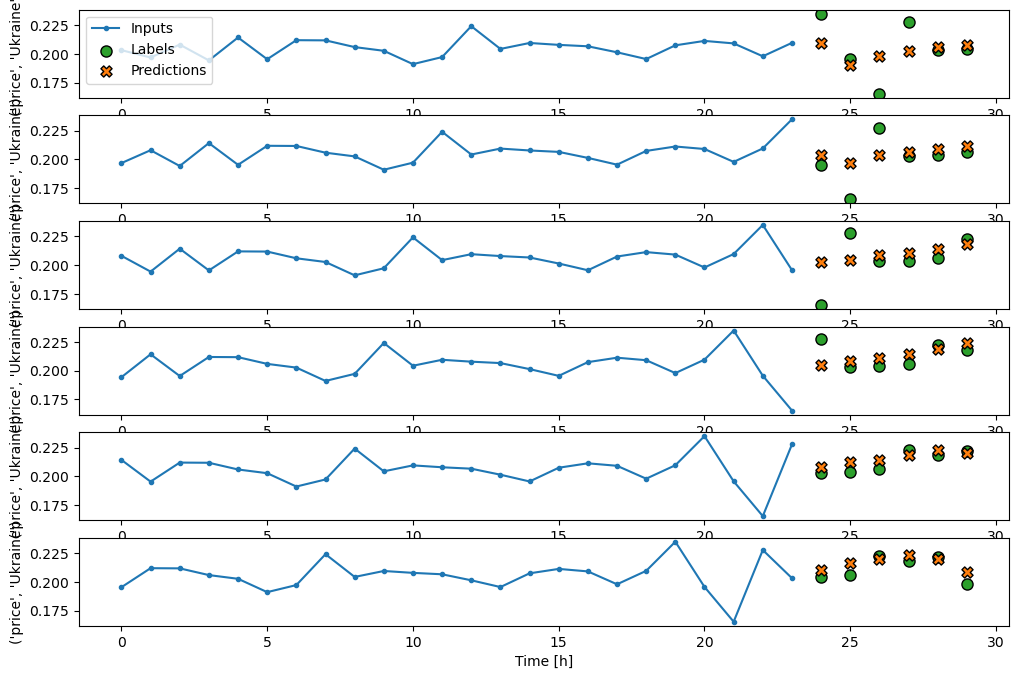

In [28]:
val_performance = {}
performance = {}

# val_performance['1'] = m.evaluate(w.val)
label = label_columns[4]
print(label)
# performance['1'] = m.evaluate(w.test)
w.plot(m_arf, plot_col=label, max_subplots=6)
